In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

In [3]:
CURRENT_DIR = Path('.').resolve()
MODULES_DIR = CURRENT_DIR.parent.joinpath('src')
sys.path.append(str(MODULES_DIR))
DATA_DIR = CURRENT_DIR.parent.joinpath('Data','Process')

# VGG16

## Leveraging on pre-trained models using transfer learning

Transfer learning is a technique in machine learning where a model trained for a certain task is modified to make predictions for another task.

![imagen](https://i.imgur.com/0m7Iia0.png)

We're goint to re-purpose the VGG16 modl to make predictions on images of cats and dogs. The VGG16 model was originally developed for the ILSVRC. VGC16 knows how to recognize specific breeds of cats and dogs, and not just cats and dogs in general. It is therefore a viable approach to use transfer learning using the VGG16 model for our cats and dosgs image classification problem

Let's create a new VGC16 model

In [21]:
from keras.applications.vgg16 import VGG16

INPUT_SIZE = 128
vgc16 = VGG16(include_top=False, weights='imagenet',
              input_shape=(INPUT_SIZE,INPUT_SIZE,3))

58889256/58889256 [==============================] - 9s 0us/step


We're now going to freeze the rest of the layers in the VGC16 model

In [22]:
for layer in vgc16.layers:
    layer.trainable = False

We add a fully connected layer with 1 node right at the end of the neural network.

In [27]:
from keras.layers import Dropout, Flatten, Dense
from keras.models import Model

In [28]:
input_ = vgc16.input
output_ = vgc16(input_)
last_layer = Flatten(name='flatten')(output_)
last_layer = Dense(1, activation='sigmoid')(last_layer)
model = Model(input_, last_layer)

In [29]:
# Define hyperparameters
BATCH_SIZE = 16
STEPS_PER_EPOCH = 200
EPOCHS = 3

In [30]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Training Model

In [32]:
from keras.preprocessing.image import ImageDataGenerator

image_generator = ImageDataGenerator(rotation_range=30,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest')

In [33]:
training_data_generator = ImageDataGenerator(rescale = 1./255)
testing_data_generator = ImageDataGenerator(rescale = 1./255)

In [34]:
training_set = training_data_generator.flow_from_directory(str(DATA_DIR.joinpath('Train')),
                                                           target_size=(INPUT_SIZE, INPUT_SIZE),
                                                           batch_size=BATCH_SIZE,
                                                           class_mode='binary')

Found 19996 images belonging to 2 classes.


In [35]:
test_set = testing_data_generator.flow_from_directory(
    str(DATA_DIR.joinpath('Test')),
    target_size=(INPUT_SIZE, INPUT_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

Found 5000 images belonging to 2 classes.


In [36]:
model.fit(training_set, steps_per_epoch= STEPS_PER_EPOCH,
          epochs=EPOCHS, verbose=1)

Epoch 1/3


2023-06-25 15:19:14.464403: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


200/200 [==============================] - 122s 584ms/step - loss: 0.3748 - accuracy: 0.8259
Epoch 2/3
200/200 [==============================] - 126s 629ms/step - loss: 0.2831 - accuracy: 0.8753
Epoch 3/3
200/200 [==============================] - 130s 647ms/step - loss: 0.2659 - accuracy: 0.8813


# Evaluate model

In [37]:
score = model.evaluate_generator(test_set, len(test_set))

/tmp/ipykernel_99045/2353313548.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  score = model.evaluate_generator(test_set, len(test_set))
2023-06-25 15:25:32.375597: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


loss: 0.2658398151397705
accuracy: 0.8858000040054321


In [54]:
print('======================')
for idx, metric in enumerate(model.metrics_names):
    print(f'{metric}: {score[idx]: .2f}')
    
print('======================')

loss:  0.27
accuracy:  0.89


# Results Analysis

In [55]:
test_set = testing_data_generator.flow_from_directory(
    str(DATA_DIR.joinpath('Test')),
    target_size=(INPUT_SIZE, INPUT_SIZE),
    batch_size=1,
    class_mode='binary'
)

Found 5000 images belonging to 2 classes.


In [56]:
strongly_wrong_idx = []
strongly_right_idx = []
weakly_wrong_idx = []

In [57]:
for i in range(test_set.__len__()):
    img = test_set.__getitem__(i)[0]
    pred_prob = model.predict(img)[0][0]
    pred_label = int(pred_prob > 0.5)
    actual_label = int(test_set.__getitem__(i)[1][0])
    if pred_label != actual_label and (pred_prob > 0.8 or
        pred_prob < 0.2): strongly_wrong_idx.append(i)
    elif pred_label != actual_label and (pred_prob > 0.4 and
        pred_prob < 0.6): weakly_wrong_idx.append(i)
    elif pred_label == actual_label and (pred_prob > 0.8 or
        pred_prob < 0.2): strongly_right_idx.append(i)
    # stop once we have enough images to plot
    if (len(strongly_wrong_idx)>=9 and len(strongly_right_idx)>=9
        and len(weakly_wrong_idx)>=9): break

1/1 [==============================] - 0s 135ms/step


In [58]:
from matplotlib import pyplot as plt
import random
def plot_on_grid(test_set, idx_to_plot, img_size=INPUT_SIZE):
    fig, ax = plt.subplots(3,3, figsize=(20,10))
    for i, idx in enumerate(random.sample(idx_to_plot,9)):
        img = test_set.__getitem__(idx)[0].reshape(img_size, img_size ,3)
        ax[int(i/3), i%3].imshow(img)
        ax[int(i/3), i%3].axis('off')

# Strongly right

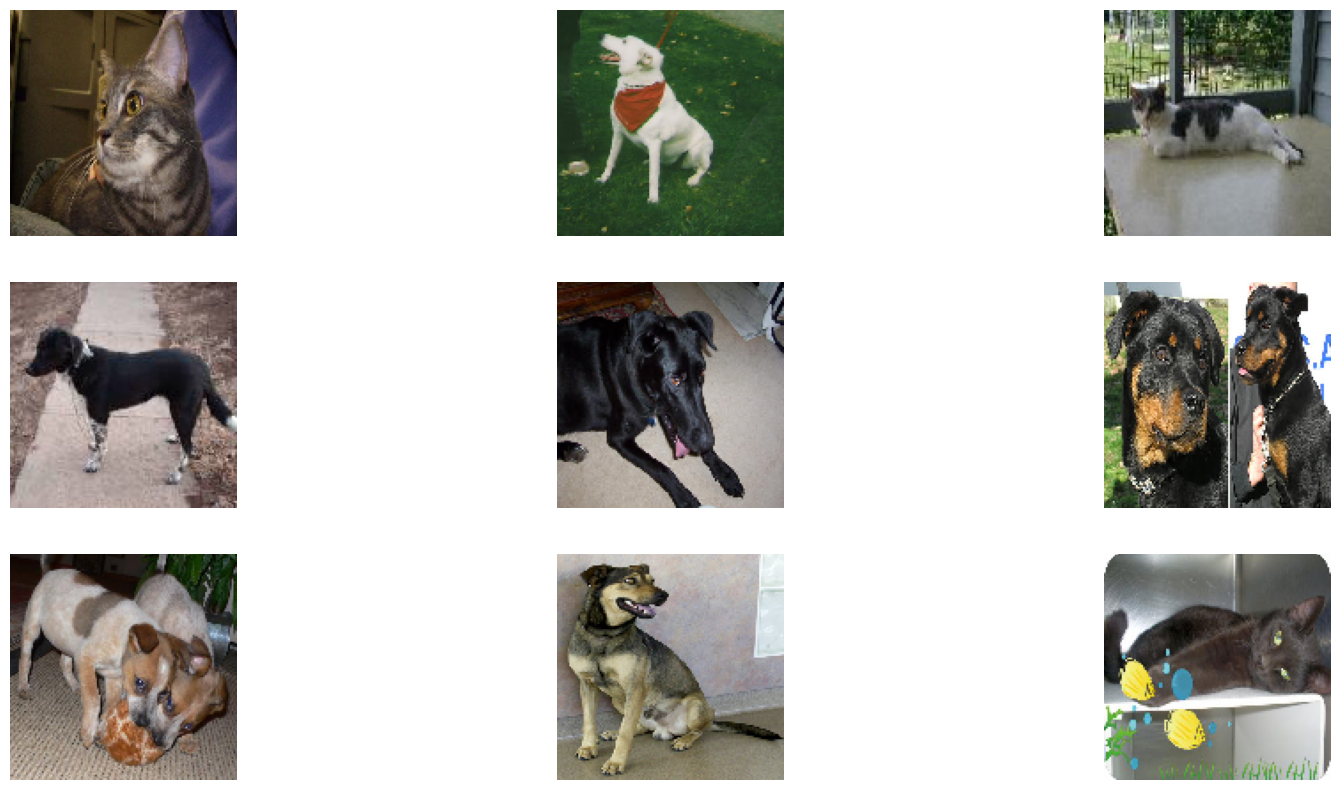

In [59]:
plot_on_grid(test_set, strongly_right_idx)

# Strongly wrong

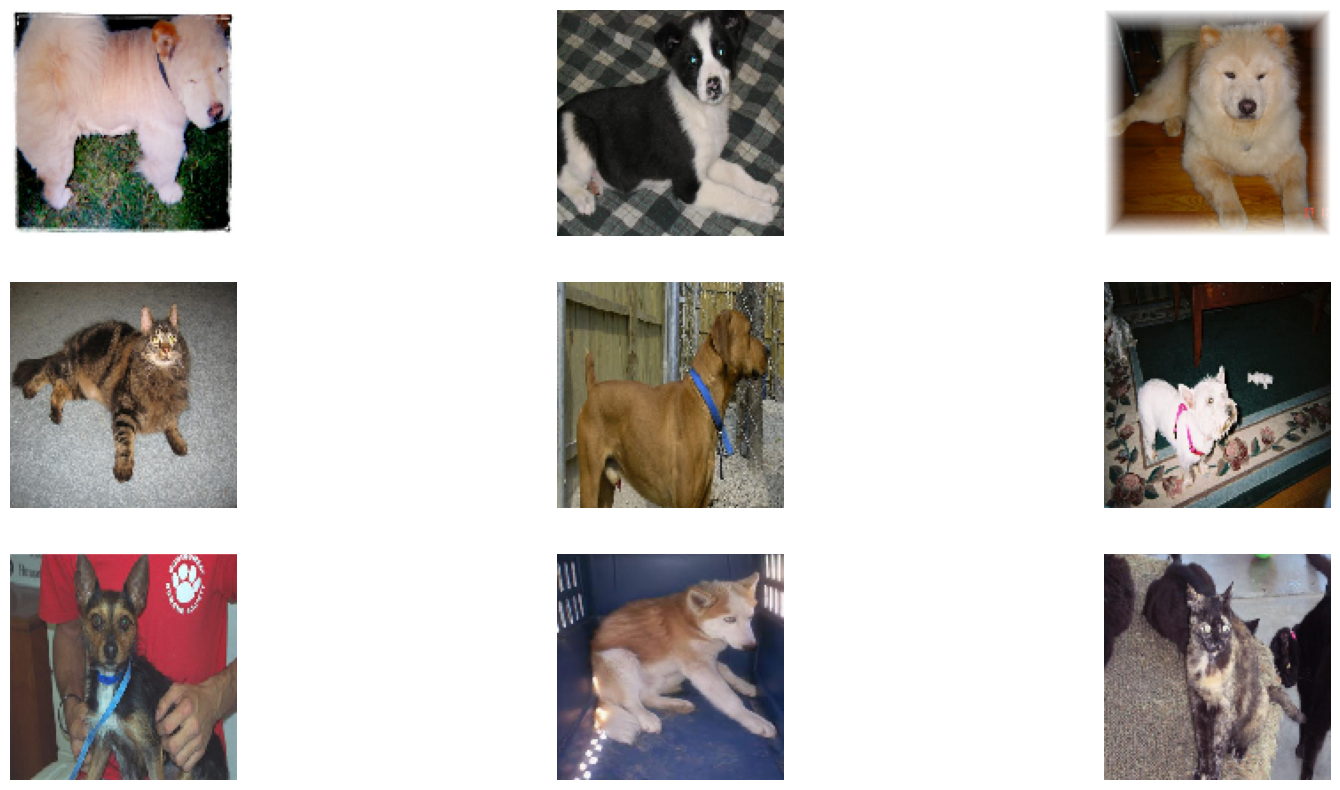

In [60]:
plot_on_grid(test_set, strongly_wrong_idx)

# Weakly wrong

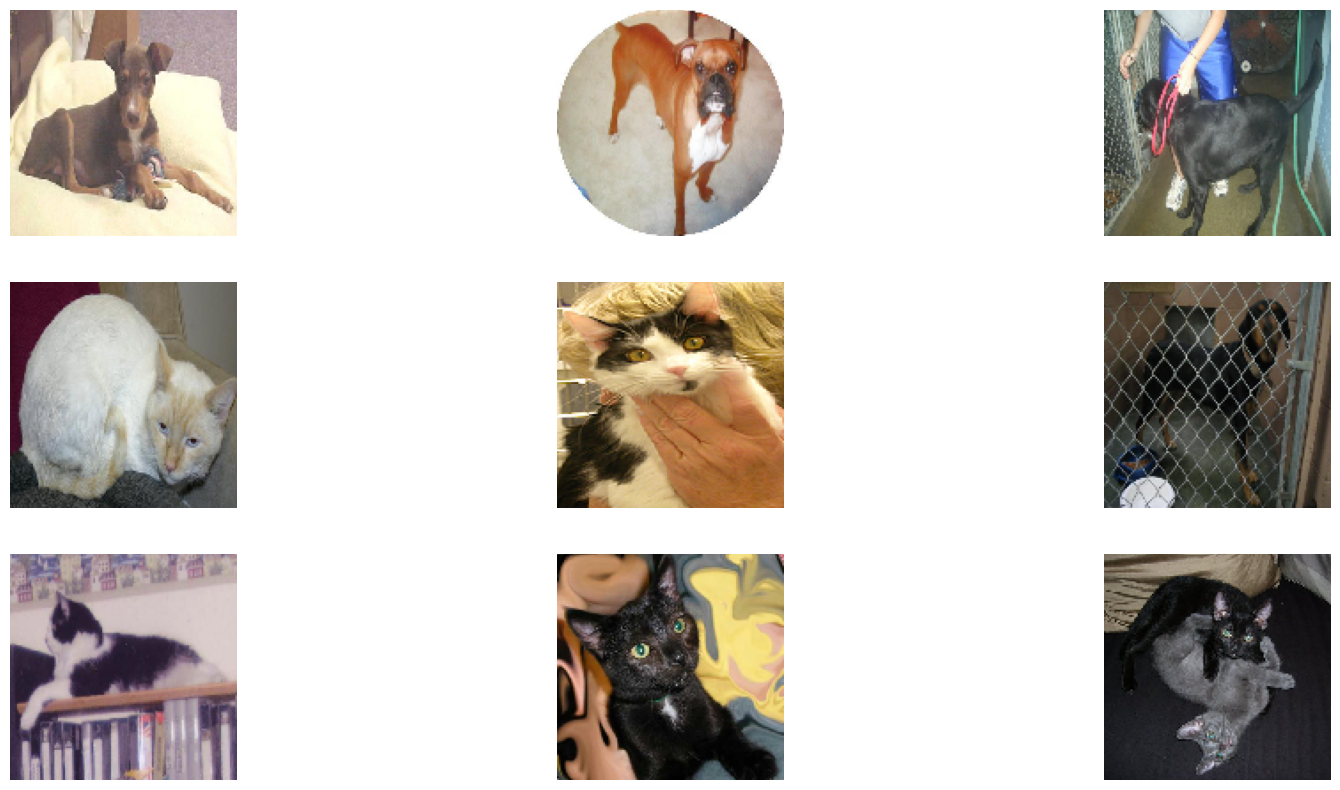

In [61]:
plot_on_grid(test_set, weakly_wrong_idx)